In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [5]:
ls

gdrive/  sample_data/


In [ ]:
!unzip /content/gdrive/MyDrive/homework8_input_data.zip

In [9]:
rm -r __MACOSX/

In [10]:
num_skipped = 0
for folder_name_1 in ("test", "training"):
    for folder_name_2 in ("daisy", "dandelion", "rose", "sunflower", "tulip"):
        folder_path = os.path.join("./flowers/", str(folder_name_1 + "/" + folder_name_2))
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 5 images


In [11]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    subset="training",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    subset="validation",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/test",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=1
)


Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


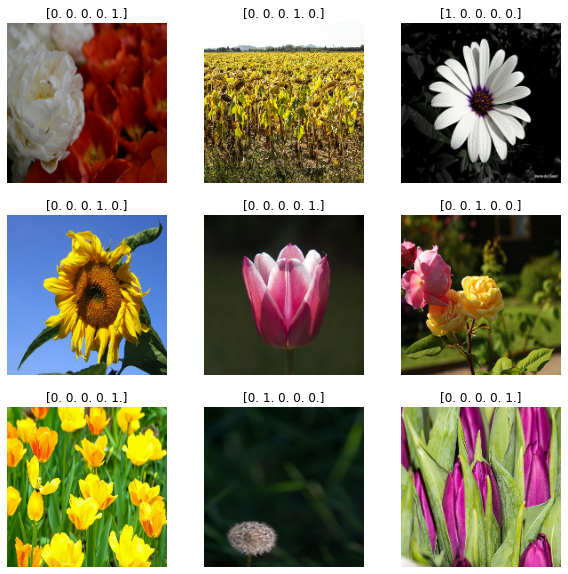

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i])[10: 26])
        plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

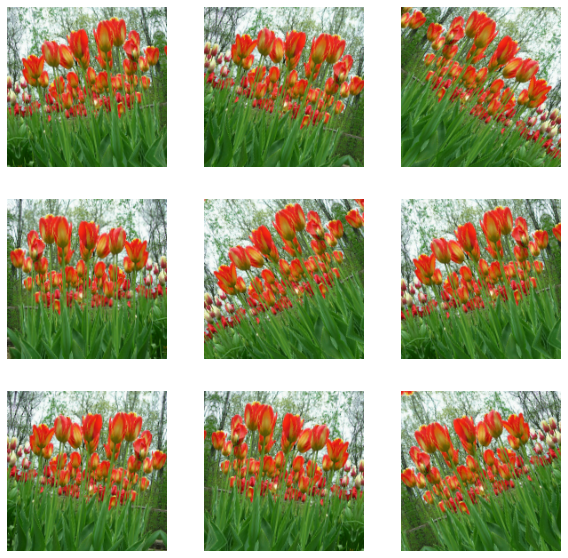

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [16]:
epochs = 22

callbacks = [
    keras.callbacks.ModelCheckpoint("saveat{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_ds
)

Epoch 1/22
87/87 [==============================] - 490s 6s/step - loss: 1.2848 - accuracy: 0.5237 - val_loss: 1.7416 - val_accuracy: 0.2590


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/22
87/87 [==============================] - 488s 6s/step - loss: 1.0640 - accuracy: 0.6061 - val_loss: 2.4914 - val_accuracy: 0.2590
Epoch 3/22
87/87 [==============================] - 484s 6s/step - loss: 0.9087 - accuracy: 0.6604 - val_loss: 3.3732 - val_accuracy: 0.2590
Epoch 4/22
87/87 [==============================] - 489s 6s/step - loss: 0.8946 - accuracy: 0.6767 - val_loss: 3.1520 - val_accuracy: 0.2590
Epoch 5/22
87/87 [==============================] - 487s 6s/step - loss: 0.7884 - accuracy: 0.7063 - val_loss: 3.9913 - val_accuracy: 0.2590
Epoch 6/22
87/87 [==============================] - 487s 6s/step - loss: 0.7384 - accuracy: 0.7219 - val_loss: 1.6534 - val_accuracy: 0.4226
Epoch 7/22
87/87 [==============================] - 486s 6s/step - loss: 0.7233 - accuracy: 0.7335 - val_loss: 1.6072 - val_accuracy: 0.5499
Epoch 8/22
87/87 [==============================] - 486s 6s/step - loss: 0.6226 - accuracy: 0.7711 - val_loss: 0.7691 - val_accuracy: 0.7236
Epoch 9/22
87

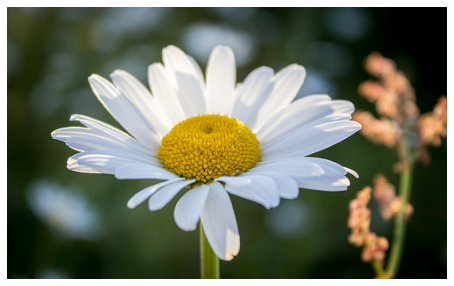

In [17]:
img = io.imread('./flowers/test/daisy/18711159980_11d3bd5042.jpg')
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img) 

In [20]:
img = keras.preprocessing.image.load_img(
    "./flowers/test/daisy/18711159980_11d3bd5042.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]


In [109]:
#print(max(predictions[0]))
#np.argmax(predictions[0])
count = 0
class_names = test_ds.class_names

                   #0  1  2  3  4
testsAccuracies = [ [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0] ]
wrongs = [[],[],[],[],[]]

for i, folder_name_1 in enumerate(["daisy", "dandelion", "rose", "sunflower", "tulip"]):
  folder_path = os.path.join("./flowers/test/", folder_name_1)
  print(folder_path)
  for j, fname in enumerate(os.listdir(folder_path)):
    img = keras.preprocessing.image.load_img(
    "./flowers/test/" + folder_name_1 + "/" + str(fname), target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    
    tmpMax = max(predictions[0])
    print(tmpMax)         
    
     
    if predictions[0][np.argmax(predictions[0])] == predictions[0][i]:
      testsAccuracies[i][i] += 1
    else:
      testsAccuracies[i][np.argmax(predictions[0])] += 1
      tmpDic = {"Expected" : class_names[i], "Actual" : class_names[np.argmax(predictions[0])], "FilePath" : folder_path + "/" + fname}
      wrongs[i].append( tmpDic )


./flowers/test/daisy
0.9999895
0.999311
0.99654764
0.99952066
0.9910005
0.9111555
0.99843603
1.0
0.99988055
0.47016928
0.67862123
0.47364295
0.9199978
1.0
0.9955049
0.9095244
0.75135463
0.4953811
0.9999292
0.50906414
0.98736763
0.98394644
0.48543465
0.92578346
0.9996013
0.99972063
0.58543646
0.82874775
0.99768686
0.9999552
0.82815063
0.9056156
0.99999297
1.0
0.99404365
0.9926439
1.0
0.8489978
0.99957997
1.0
0.99968314
0.99999297
0.9303951
0.963999
0.99989045
0.99999964
0.9985983
0.8856274
0.9124529
0.99505484
0.9999999
0.90585005
0.9999615
0.93304735
0.9971264
0.970145
0.99999213
0.99962795
0.99906415
0.36851436
0.69896865
0.9999913
0.9968616
0.99979967
0.99620855
0.99900657
0.9746074
1.0
0.99464405
0.9996376
0.99959105
0.9998958
0.55886227
0.99998975
0.9999572
0.4441137
1.0
0.99997747
0.9998109
0.99621874
0.5847474
0.99990726
0.9021667
0.9975926
1.0
0.99999666
0.99009365
0.9022089
0.9996019
0.9221018
0.47554797
0.99976605
0.5908703
0.9987437
0.9955407
0.99998415
0.61035264
0.99998164


In [110]:
testsAccuracies

[[102, 32, 16, 2, 1],
 [2, 200, 5, 3, 0],
 [8, 19, 110, 5, 14],
 [13, 36, 5, 91, 1],
 [13, 30, 64, 5, 84]]

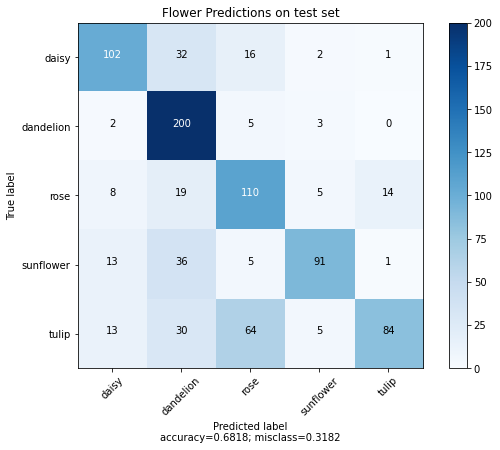

In [111]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

true_labels = ['daisy', 'dandelion', 'rose','sunflower','tulip']

plot_confusion_matrix(cm           = np.array(testsAccuracies), 
                      normalize    = False,
                      target_names = ['daisy', 'dandelion', 'rose','sunflower','tulip'],
                      title        = "Flower Predictions on test set")

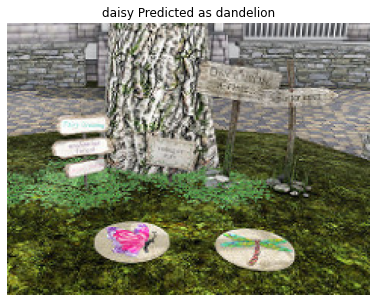

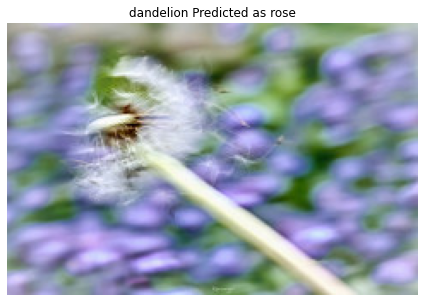

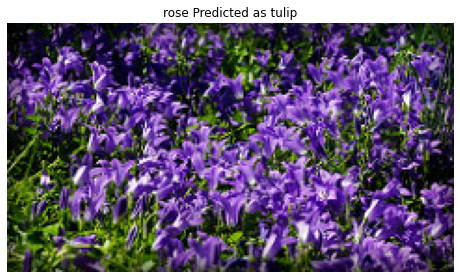

In [112]:
for i in range(3):
  img = io.imread(wrongs[i][0]["FilePath"])
  plt.figure(figsize=(8, 5))
  plt.axis("off")
  plt.title(wrongs[i][0]["Expected"] + " Predicted as " + wrongs[i][0]["Actual"])
  plt.imshow(img)